Проанализируйте данные по ирисам (iris):
1. Выполните кластеризацию методом k-средних;
2. Определите оптимальное кол-во кластеров на основе подходящего критерия; оцените устойчивость распределения;
4. Опишите свойства кластеров;
5. Найдите переменные, значимые для кластеризации.


# Загрузка данных и предобработка

1. Произведем загрузку данных iris

In [73]:
from sklearn import datasets
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

iris = datasets.load_iris()
df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2.0
146,6.3,2.5,5.0,1.9,2.0
147,6.5,3.0,5.2,2.0,2.0
148,6.2,3.4,5.4,2.3,2.0


2. Подсчитаем количество различных видов iris представленных в датасете для дальнейшего использование в качестве гиперпараметра K-means алгоритма

In [74]:
df['target'].value_counts()

target
0.0    50
1.0    50
2.0    50
Name: count, dtype: int64

3. Вычислим стандартизированные значения для улучшения алгоритма кластеризации

In [75]:
FEATURES = []
for col in df.columns.drop('target'):
    df['st_' + col] = (df[col] - df[col].mean()) / df[col].std()
    FEATURES.append('st_' + col)
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,st_sepal length (cm),st_sepal width (cm),st_petal length (cm),st_petal width (cm)
0,5.1,3.5,1.4,0.2,0.0,-0.897674,1.015602,-1.335752,-1.311052
1,4.9,3.0,1.4,0.2,0.0,-1.139200,-0.131539,-1.335752,-1.311052
2,4.7,3.2,1.3,0.2,0.0,-1.380727,0.327318,-1.392399,-1.311052
3,4.6,3.1,1.5,0.2,0.0,-1.501490,0.097889,-1.279104,-1.311052
4,5.0,3.6,1.4,0.2,0.0,-1.018437,1.245030,-1.335752,-1.311052
...,...,...,...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2.0,1.034539,-0.131539,0.816859,1.443994
146,6.3,2.5,5.0,1.9,2.0,0.551486,-1.278680,0.703564,0.919223
147,6.5,3.0,5.2,2.0,2.0,0.793012,-0.131539,0.816859,1.050416
148,6.2,3.4,5.4,2.3,2.0,0.430722,0.786174,0.930154,1.443994


In [76]:
df.std()

sepal length (cm)       0.828066
sepal width (cm)        0.435866
petal length (cm)       1.765298
petal width (cm)        0.762238
target                  0.819232
st_sepal length (cm)    1.000000
st_sepal width (cm)     1.000000
st_petal length (cm)    1.000000
st_petal width (cm)     1.000000
dtype: float64

4. Визуализируем реальное разбиение на кластеры данных по двум параметрам

<Axes: xlabel='sepal length (cm)', ylabel='petal length (cm)'>

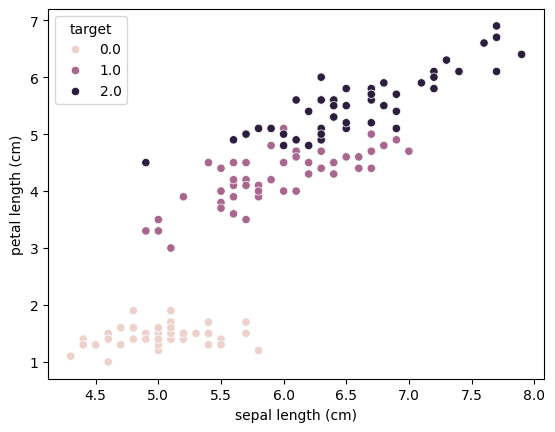

In [77]:
import seaborn as sns
sns.scatterplot(data=df, x="sepal length (cm)", y="petal length (cm)", hue="target")

# К средних с относительной валидацией

## Метод локтя

Произведем кластеризацию методов K means используя "метод локтя".

Строим график зависимости суммы квадрата ошибок (SSE) от количества кластеров. Выбираем оптимальное количество кластеров после которого уменьшение ошибки становится незначительным.

$SSE = \sum_{j=1}^k \sum_{i\in C_j} (x_i - \mu_j)^2$

Сумма квадрата ошибок есть Евклидово расстояние от точки, до центроида кластерав квадрате по всем кластерам по всем объектам

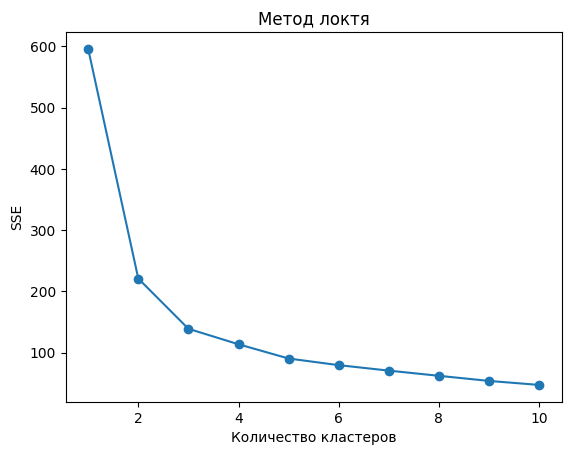

In [78]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt


sse = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(df[FEATURES])
    sse.append(kmeans.inertia_)

# Построение графика
plt.plot(k_range, sse, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('SSE')
plt.title('Метод локтя')
plt.show()

Как можно заметить "локоть" после которого уменьшение ошибки становится незначительным находится на значении 3,4

## Метод силуэта

Метод силуэта оценивает, насколько объект находится в своем кластере по сравнению с другими кластерами. Средний коэффициент силуэта для всех объектов в наборе данных используется для оценки качества кластеризации. Оптимальное количество кластеров соответствует максимальному среднему значению силуэта.

1. Вычисляется внутрикластерное расстояние - среднее расстояние от объекта до всех других объектов в этом кластере:
$$ a_i = \dfrac{1}{|C_i| -1} \sum_{j\in C_i, j\neq i} d(i,j)$$

2. Вычисляем межкластерное расстояние - для каждого кластера $C$ не содержащего $i$ объект вычисляем среднее расстояние между $i$ и всеми объектами кластера $C$

$$d(i,C) = \dfrac{1}{|c|} \sum_{j\in C} d(i,j) $$

Из всех таких расстояний выбираем наименьшее (т.е. расстояние до ближайшего кластера

$$b(i) = min_{C \neq C_i} d(i,C)$$

Тогда коэффициентом силуэта назовем:

$$ s(i) = \dfrac{b(i) - a(i) }{max(a(i), b(i))}$$

Свойства:
Находится в диапазоне $(-1;1)$

Интерпретация:
Если коэффициент близко к 1 то $i$ объект хорошо соотвествует кластеру и плохо соотвествует соседним кластерам

Если коэффициент близко к -1 то $i$ объект относится к другому кластеру

Если коэффимциент в окрестности 0, то он находится на границе двух кластеров

Соответственно усреднив возможно рассчитать средний коэффициент силуэта:

$$ S = \dfrac{1}{N} \sum^N_{i=1}s(i)$$

Если коэффицент близок к 1 - кластера хорошо различимы

Если коэффициент близок к 0 - существует перекрытие кластеров

Если коэффициент отрицателен - объекты чаще находятся в других кластерах и кластеризация плохая


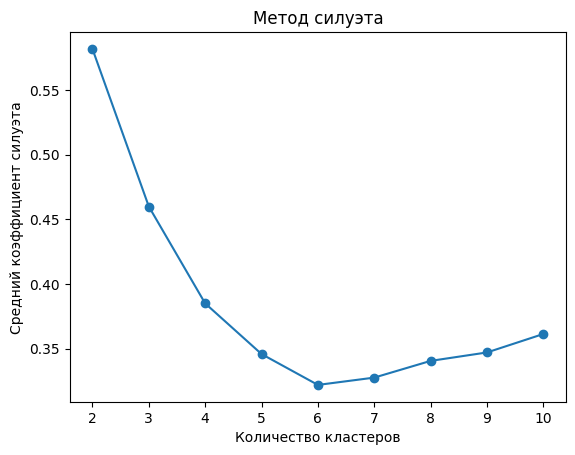

In [79]:
from sklearn.metrics import silhouette_score


silhouette_scores = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(df[FEATURES])
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(df[FEATURES], labels))

# Построение графика
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Средний коэффициент силуэта')
plt.title('Метод силуэта')
plt.show()

Видим что коэффициент силуэта стремительно падает, увеличивая перекрытие кластеров с их ростом. Оптимальные значения 2,3


## Внешняя валидация, проверка с заранее известным количеством кластеров

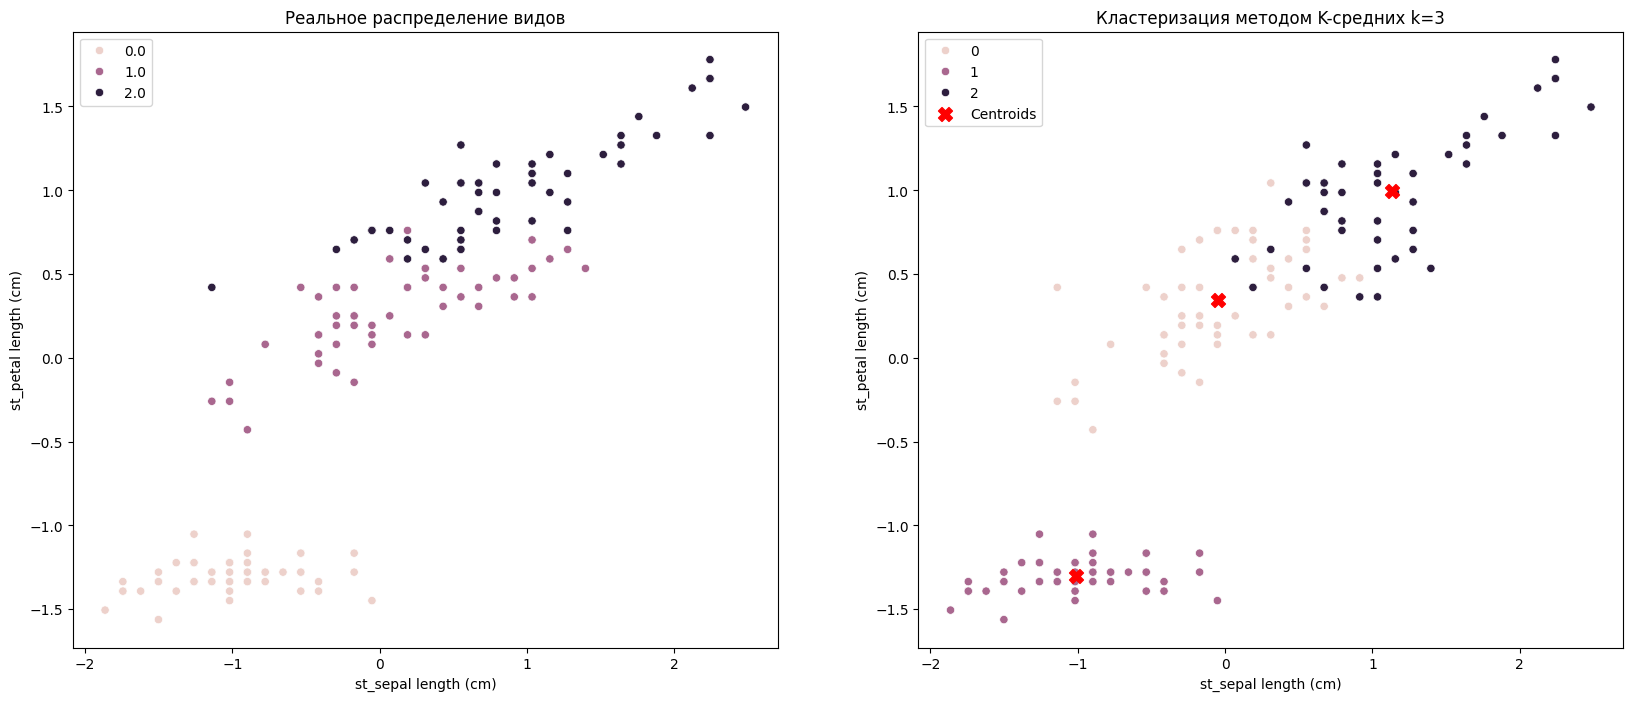

In [80]:
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(df[FEATURES])
df['predict'] = kmeans.labels_
centroids = kmeans.cluster_centers_

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

sns.scatterplot(ax=axes[0], data=df, x="st_sepal length (cm)", y="st_petal length (cm)", hue="target")

axes[0].set_title('Реальное распределение видов')
axes[0].set_xlabel('st_sepal length (cm)')
axes[0].set_ylabel('st_petal length (cm)')
axes[0].legend()

sns.scatterplot(ax=axes[1], data=df, x="st_sepal length (cm)", y="st_petal length (cm)", hue="predict")
axes[1].scatter(centroids[:, 0], centroids[:, 2], s=100, c='red', marker='X', label='Centroids')


axes[1].set_title('Кластеризация методом K-средних k=3')
axes[1].set_xlabel('st_sepal length (cm)')
axes[1].set_ylabel('st_petal length (cm)')
axes[1].legend()

plt.show()

## Описание свойств кластеров

Для описания кластеров используем следующие параметры:
1. Центроиды
2. Размеры кластеров
3. Внутрикластерная дисперсия

Внутрикластерная дисперсия (Within-Cluster Sum of Squares, WCSS) - оценивает плотность кластера путем расчета разброса точек относительно центроида

$$ WCSS_i = \sum_{x \in C_i}||x-\mu_i||^2$$

In [81]:
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

from tabulate import tabulate

# Описание свойств кластеров
cluster_properties = []

for cluster in df['predict'].unique():
    cluster_data = df[df['predict'] == cluster]
    centroid = centroids[cluster]
    size = len(cluster_data)
    wcss = np.sum((cluster_data[iris.feature_names] - centroid) ** 2)

    print(f'Cluster: {cluster}')
    print(f'Centroid: {centroid}')
    print(f'Size: {size}')
    print(f'WCSS:\n{wcss}')
    print('-'*50)

Cluster: 1
Centroid: [-1.01119138  0.85041372 -1.30063009 -1.25070352]
Size: 50
WCSS:
sepal length (cm)    1816.417807
sepal width (cm)      339.238353
petal length (cm)     383.084051
petal width (cm)      112.550271
dtype: float64
--------------------------------------------------
Cluster: 2
Centroid: [1.13217737 0.08812645 0.99282844 1.01412869]
Size: 47
WCSS:
sepal length (cm)    1510.725948
sepal width (cm)      428.310218
petal length (cm)     978.023157
petal width (cm)       48.188019
dtype: float64
--------------------------------------------------
Cluster: 0
Centroid: [-0.05005221 -0.88042696  0.34657675  0.28058731]
Size: 53
WCSS:
sepal length (cm)    1823.544887
sepal width (cm)      672.806036
petal length (cm)     874.211769
petal width (cm)       73.030671
dtype: float64
--------------------------------------------------


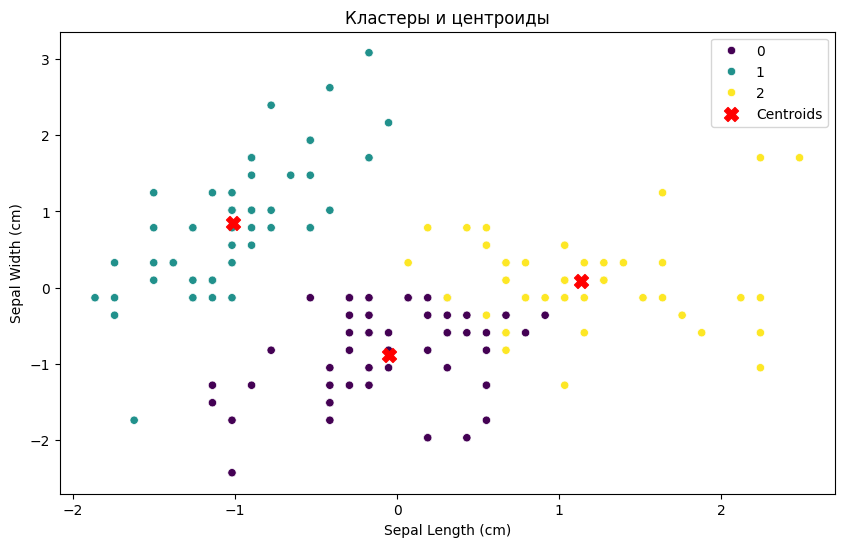

In [82]:
# Визуализация кластеров и центроидов
plt.figure(figsize=(10, 6))
sns.scatterplot(x='st_sepal length (cm)', y='st_sepal width (cm)', hue='predict', data=df, palette='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], s=100, c='red', marker='X', label='Centroids')
plt.title('Кластеры и центроиды')
plt.xlabel('Sepal Length (cm)')
plt.ylabel('Sepal Width (cm)')
plt.legend()
plt.show()

## Оценка значимости переменных

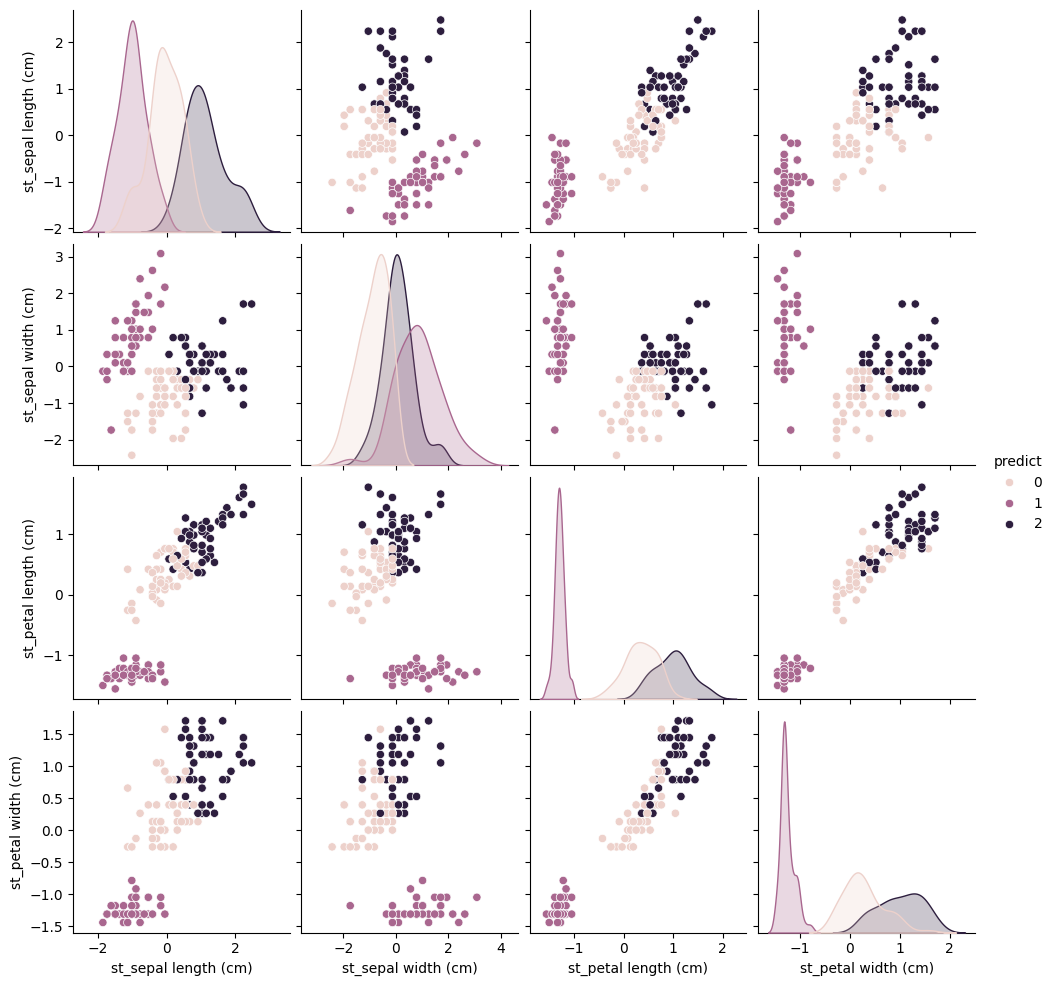

In [83]:
# Pairplot для визуализации
sns.pairplot(df[FEATURES + ['predict']], hue='predict')
plt.show()

## Оценка устойчивости распределения

Произведем bootstrap выборку с заменой и произведем кластеризацию на каждой из них при этом будем задавать различный random state инициализуя каждый раз начальное положение центроидов случайным образом

Для оценки используем ARI (Adjusted Rand Index) - скорректированный индекс Рэнда.

Индекс Рэнда - отношение суммы количества пар точек, находящихся в одинаковых кластерах в обоих разбиениях, и количества пар точек, находящихся в разных кластерах в обоих разбиениях, к общему числу пар точек

$$RI = \dfrac{TP + TN}{TP + TN + FP + FN}$$

TP - находятся в одном кластере в действительном и в предсказанном разбиении

TN - находятся в разных кластерах в действительном и в предсказанном разбиении

FP -  пары точек, находящихся в одном кластере в предсказанном разбиении, но в разных кластерах в истинном разбиении

FN - пары точек, находящихся в разных кластерах в предсказанном разбиении, но в одном кластере в истинном разбиении

Индекс Рэнда не учитывает вероятность случайного совпадения кластеров. ARI корректирует индекс Рэнда, вычитая ожидаемое значение индекса Рэнда для случайных кластеризаций и деления на максимальное значение индекса Рэнда:

$$ ARI = \dfrac{RI - E[RI]}{max(RI) - E[RI]}$$

$RI$ - индекс Рэнда

$E[RI]$ - ожидаемое значение индекса Рэнда

Значение ARI находится в диапазоне от -1 до 1:

1. Значение 1 указывает на идеальное совпадение кластеризаций.

2. Значение 0 указывает на совпадение, которое можно ожидать случайным образом.

3. Отрицательные значения указывают на совпадение хуже случайного.

Adjusted Rand Index (ARI) оценивает согласованность кластеров между исходным набором данных и каждым bootstrap-набором.

Гистограмма распределения значений ARI показывает, насколько устойчивы кластеры.

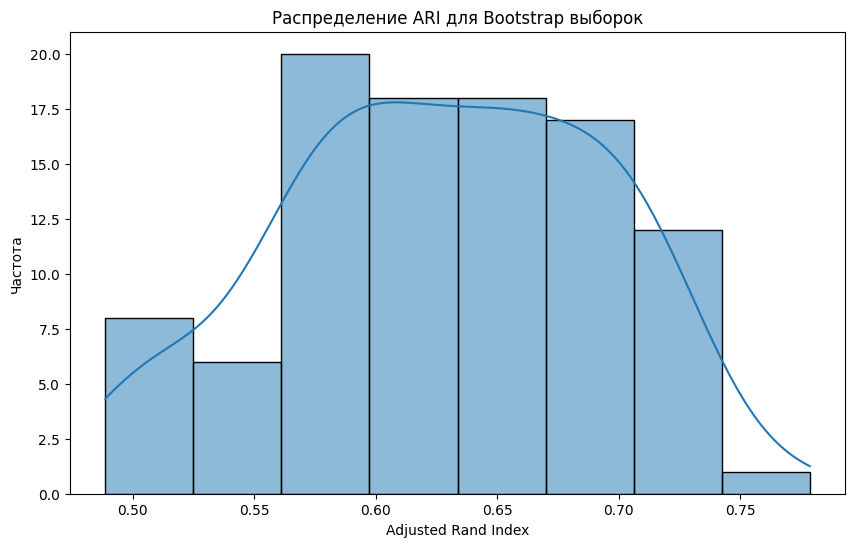

Средний ARI: 0.627
Стандартное отклонение ARI: 0.066


In [84]:
from sklearn.metrics import adjusted_rand_score

def run_kmeans(X, n_clusters, random_state=None):
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    kmeans.fit(X)
    return kmeans.cluster_centers_, kmeans.labels_

n_bootstraps = 100
n_clusters = 3
bootstrap_scores = []

for i in range(n_bootstraps):
    indices = np.random.choice(range(len(df[FEATURES])), size=df.shape[0], replace=True)
    X_bootstrap = df.iloc[indices][FEATURES]
    y_bootstrap = df.iloc[indices]['target']

    _, labels_bootstrap = run_kmeans(X_bootstrap, n_clusters=n_clusters, random_state=i)

    score = adjusted_rand_score(y_bootstrap, labels_bootstrap)
    bootstrap_scores.append(score)

plt.figure(figsize=(10, 6))
sns.histplot(bootstrap_scores, kde=True)
plt.xlabel('Adjusted Rand Index')
plt.ylabel('Частота')
plt.title('Распределение ARI для Bootstrap выборок')
plt.show()

mean_ari = np.mean(bootstrap_scores)
std_ari = np.std(bootstrap_scores)
print(f'Средний ARI: {mean_ari:.3f}')
print(f'Стандартное отклонение ARI: {std_ari:.3f}')